In [1]:
import sys
import xarray as xr
import numpy as np
import Plotter
from Plotter import Plotter
import time
from preprocessing_utils import *
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pyxpcm
from pyxpcm.models import pcm
import warnings
import glob

from clustergram import Clustergram
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import urbangrammar_graphics as ugg

sns.set(style='whitegrid')

warnings.filterwarnings('ignore')

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
def train_model(k, x, algo):
    if algo == "kmean":
        print("model used: kmean")
        model = sklearn.cluster.KMeans(n_clusters=k, n_init=10, max_iter=1000)
    elif algo == "batch":
        print("model used: mini batch kmean")
        model = sklearn.cluster.MiniBatchKMeans(n_clusters=k, n_init=10, max_iter=1000, batch_size=100)
    else:
        print("model used: GMM")
        model = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-6)
    model.fit(x)
    return model

In [4]:
def score_model(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    print("sample")
    print(f"model score (higher is best): {m.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, pred)}")
    print("---------------------------------------------------")
    print("full")
    print(f"model score (higher is best): {m_full.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, truth)}")
    print("---------------------------------------------------")
    print(f" adjusted rand score: {metrics.adjusted_rand_score(truth, pred)}")
    print(f" unadjusted rand score: {metrics.rand_score(truth, pred)}")
    print("---------------------------------------------------")
    print(f" adjusted mutual info score: {metrics.adjusted_mutual_info_score(truth, pred)}")
    print(f" unadjusted mutual info score: {metrics.mutual_info_score(truth, pred)}")

#     print(f"model score: {m.score(x)}")
#     print(f"model score: {m.score(x)}")

In [5]:
# def predict(x, m, var_name_ds, k, var_predict):
#     classif = m.predict(x[var_predict])
#     x = x.assign(variables={"labels": ('sample_dim', classif)})
#     q = [0.05, 0.5, 0.95]
#     x = compute_quantile2(x, var_name_ds, k, q)
#     x = x.assign_coords(coords={'k': range(k)})
#     x = x.unstack('sample_dim')
#     return x

In [6]:
def generate_plots(ds, var_name_ds, k, algorithm):
    """
    Generates and saves the following plots:
    - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
    - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
    differences between classes.
    - Spacial distribution: plot the PCM labels in a map to analyse the spatial coherence of classes.
    - Robustness: spacial distribution of a scaled probability of a profile to belong to a class.
    - Pie chart: pie chart showing the percentage of profiles belonging to each class and the number of
    classified profiles.
    - Temporal distribution by month: The bar plots represents the percentage of profiles in each class by month.
    - Temporal distribution by season: The bar plots represents the percentage of profiles in each class by season.
    Parameters
    ----------
    ds : Xarray dataset containing the predictions
    var_name_ds : name of the variable in the dataset

    Returns
    -------
    saves all the plots as png
    """
    try:
        x_label = ds[var_name_ds].attrs['long_name'] + " in " + ds[var_name_ds].attrs['unit_long']
    except KeyError:
        x_label = var_name_ds

    # create a pyXpcm model to use the Plotter class
    var_name_mdl = var_name_ds
    z_dim = 'depth'
    z = ds[z_dim]
    pcm_features = {var_name_mdl: z}
    m = pcm(K=k, features=pcm_features)
    ds = ds.rename({'labels': 'PCM_LABELS'})
    ds = ds.sortby('latitude').sortby('longitude')
    P = Plotter(ds, m, coords_dict={'latitude': 'latitude', 'longitude': 'longitude', 'time': 'time', 'depth': 'depth'})

    # plot profiles by class
    P.vertical_structure(q_variable=var_name_ds + '_Q', sharey=True, xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc{algorithm}.png')
    # plot profiles by quantile
    P.vertical_structure_comp(q_variable=var_name_ds + '_Q', plot_q='all', xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc_comp{algorithm}.png')
    # spacial distribution
#     P.spatial_distribution(time_slice='most_freq_label')
#     P.save_BlueCloud(f'./GMM_scaling_out/spatial_distr_freq{algorithm}.png')
    # robustness
    # P.plot_robustness(time_slice=first_date)
    # P.save_BlueCloud('robustness.png')
    # pie chart of the classes distribution
    P.pie_classes()
#     P.save_BlueCloud(f'./GMM_scaling_out/pie_chart{algorithm}.png')
    # temporal distribution (monthly)
    try:
        P.temporal_distribution(time_bins='month')
#         P.save_BlueCloud('temporal_distr_months.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_months')
        print('plot monthly temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)
    # temporal distribution (seasonally)
    try:
        P.temporal_distribution(time_bins='season')
#         P.save_BlueCloud('temporal_distr_season.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_season')
        print('plot seasonal temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)

# Execution of the code

## parameters

In [7]:
# var_name_ds = "TEMP"
var_name_ds = 'thetao'
var_name_mdl = "temperature"
# algorithm choice can be: "kmean" for classic sklarn kmean, "batch" for sklearn kmean mini-batch, "GMM" for sklearn GMM
algorithm = "batch"
k = 8
# file_name = '../datasets/global-reanalysis-phy-001-030-monthly_big.nc'
# dir_path = '/home/ref-coriolis-public/copernicus/INSITU_GLO_TS_OA_REP_OBSERVATIONS_013_002_b/CORIOLIS-GLOBAL-CORA-OBS_FULL_TIME_SERIE/field/'
# file_list = glob.glob(f"{dir_path}2019/*TEMP.nc")
# file_list+=glob.glob(f"{dir_path}2018/*TEMP.nc")

dir_path = "../datasets/"
# file_list = glob.glob(f"{dir_path}global-reanalysis-phy-001-030-monthly_big.nc")
file_list = glob.glob(f"{dir_path}global-reanalysis-phy-001-030-monthly_med*.nc")

print(len(file_list))

len(file_list)
# spacial_domain = {"lon":[-5, 42],
#                  "lat": [30, 46],
#                  "depth": 800}
spacial_domain = {"lon":[-80, 80],
                 "lat": [-80, 80],
                 "depth": 800}
spacial_domain

1


{'lon': [-80, 80], 'lat': [-80, 80], 'depth': 800}

## Load and preprocessing
see in file preprocessing utils for details

In [8]:
%lprun -f preprocessing_allin x = preprocessing_allin(path=file_list, scaling=True, multiple=True, backend='sk', var_name=var_name_ds, n_comp_pca=15, spacial_domain=spacial_domain)

size full DS: 0.1998654119670391 Go
size after selection of variable: 0.16574254631996155 Go


Timer unit: 1e-06 s

Total time: 1.91674 s
File: /export/home/lbachelo/Documents/BlueCloud/speed_test/preprocessing_utils.py
Function: preprocessing_allin at line 90

Line #      Hits         Time  Per Hit   % Time  Line Contents
    90                                           def preprocessing_allin(path, scaling, backend, multiple, var_name, n_comp_pca, spacial_domain='glob'):
    91         1      16789.0  16789.0      0.9      ds = read_dataset(path, multiple, backend)
    92         1     940464.0 940464.0     49.1      ds = select_var(ds, var_name, multiple, backend, spacial_domain)
    93         1     218331.0 218331.0     11.4      x = filter_profiles(ds)
    94                                               #     interpolation and drop all nan not used since they are all filtered in "filter_profiles"
    95                                               #     x = interpolation(x, 'depth')
    96                                               #     x = drop_all_NaN(x)
    97    

## subsampling for training

In [9]:
var_train = var_name_ds + "_scaled_reduced"
x

<xarray.Dataset>
Dimensions:                (depth: 34, feature: 34, feature_reduced: 15, sample_dim: 339420)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -643.6 -763.3
  * sample_dim             (sample_dim) MultiIndex
  - longitude              (sample_dim) float64 -5.0 -5.0 -5.0 ... 41.33 41.33
  - latitude               (sample_dim) float64 36.0 36.0 36.0 ... 41.75 41.75
  - time                   (sample_dim) datetime64[ns] 2018-01-16T12:00:00 .....
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (sample_dim, depth) float32 16.66 16.66 ... 8.839
    thetao_scaled          (sample_dim, feature) float32 -0.7208 ... -2.201
    thetao_scaled_reduced  (sample_dim, feature_reduced) float32 1.158 ... 0....
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [10]:
# var_train = var_name_ds + "_scaled_reduced"
# train_size = len(x[var_name_ds])-1
# x_train, x_test = train_test_split(x[var_train], test_size=1, train_size=train_size, random_state=42)
# print(f"x_train: {x_train.shape}")
# print(f"x_test: {x_test.shape}")

## Training

In [11]:
cgram = Clustergram(range(1, 10), n_init=1, method="gmm")
cgram.fit(x[var_train])

K=1 fitted in 0.7871572971343994 seconds.
K=2 fitted in 1.9970920085906982 seconds.
K=3 fitted in 13.67012643814087 seconds.
K=4 fitted in 34.70594525337219 seconds.
K=5 fitted in 27.571288347244263 seconds.
K=6 fitted in 27.155356407165527 seconds.
K=7 fitted in 35.49097228050232 seconds.
K=8 fitted in 25.597437381744385 seconds.
K=9 fitted in 26.333818674087524 seconds.


Text(0.5, 1.0, 'Gaussian Mixture Model (scikit-learn)')

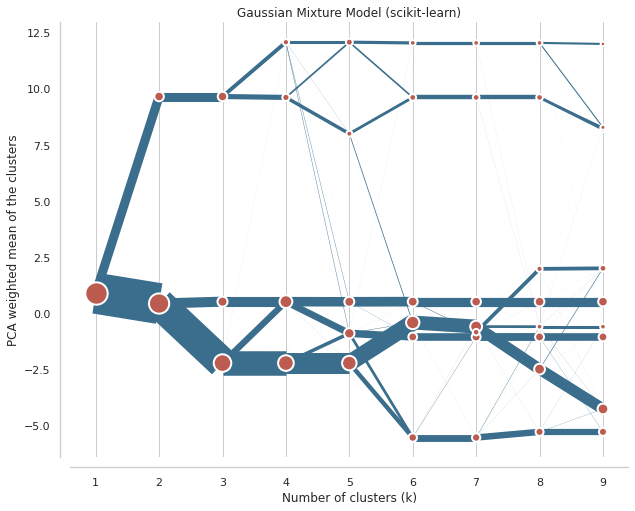

In [12]:
ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title("Gaussian Mixture Model (scikit-learn)")

In [15]:
print("starting computation")
start_time = time.time()
m = train_model(k=k, x=x[var_train], algo=algorithm)
train_time = time.time() - start_time
print("training finished in " + str(train_time) + "sec")

starting computation
model used: mini batch kmean
training finished in 3.4268972873687744sec


# evaluate model

In [12]:
# %%time
# score_model(m=m, m_full=m_full, x=x_test)

## Prediction and quantile computation

In [16]:
%lprun -f predict ds = predict(m=m, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)

Timer unit: 1e-06 s

Total time: 21.0002 s
File: /export/home/lbachelo/Documents/BlueCloud/speed_test/preprocessing_utils.py
Function: predict at line 129

Line #      Hits         Time  Per Hit   % Time  Line Contents
   129                                           def predict(x, m, var_name_ds, k, var_predict):
   130         1    4536356.0 4536356.0     21.6      classif = m.predict(x[var_predict])
   131         1      87029.0  87029.0      0.4      x = x.assign(variables={"labels": ('sample_dim', classif)})
   132         1          2.0      2.0      0.0      q = [0.05, 0.5, 0.95]
   133         1    3205782.0 3205782.0     15.3      x = compute_quantile2(x, var_name_ds, k, q)
   134         1       1434.0   1434.0      0.0      x = x.assign_coords(coords={'k': range(k)})
   135         1   13169632.0 13169632.0     62.7      x = x.unstack('sample_dim')
   136         1          2.0      2.0      0.0      return x

## Plots

In [ ]:
%%time
name_ext = '_trainsize' + str(train_size)
# name_ext = '_full2'
start_time = time.time()
generate_plots(ds=ds, var_name_ds=var_name_ds, k=k, algorithm=algorithm)
plot_time = time.time() - start_time
print("plot finished in " + str(plot_time) + "sec")
tmp_log = {
    'ncpu': 8,
    'ram': 16,
    'platform': "local",
    'time_load': load_time,
    'time_train': train_time,
    'time_prediction': prediction_time,
    'time_plot': plot_time,
    'total_time': load_time + train_time + prediction_time + plot_time,
    'file_size': (ds.nbytes / 1073741824),
}
print(tmp_log)
print("exec time saved")

In [13]:
%load_ext line_profiler

Figure saved in ./GMM_scaling_out/vertical_strucbatch.png
Figure saved in ./GMM_scaling_out/vertical_struc_compbatch.png
Figure saved in ./GMM_scaling_out/spatial_distr_freqbatch.png
Figure saved in ./GMM_scaling_out/pie_chartbatch.png
Figure saved in temporal_distr_months.png
Figure saved in temporal_distr_season.png


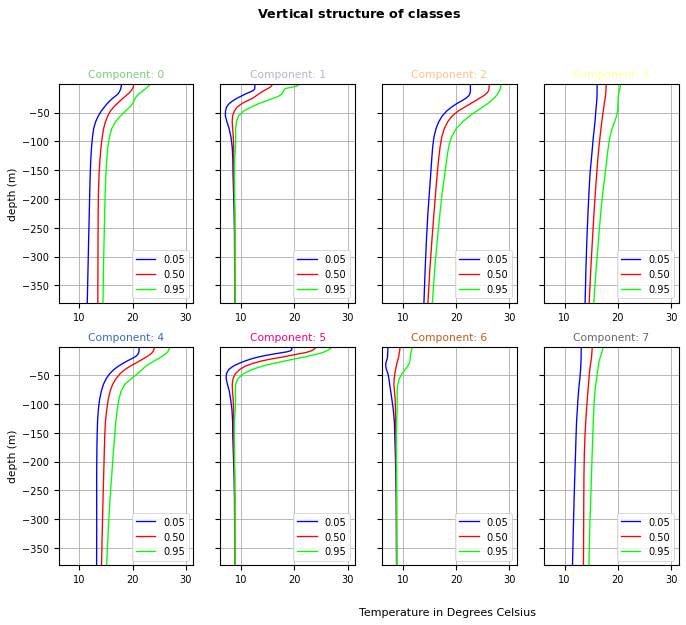

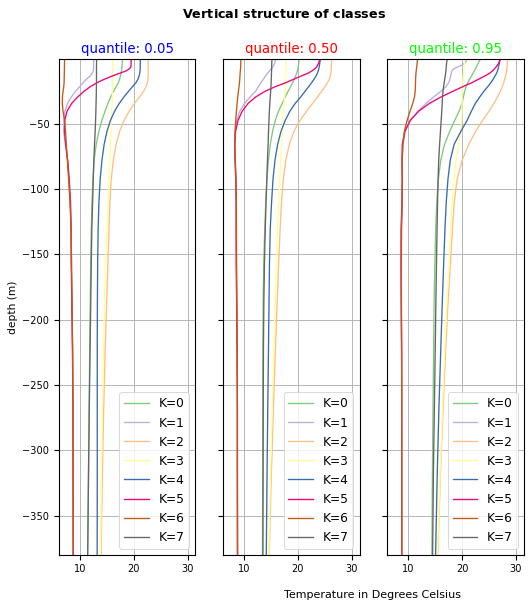

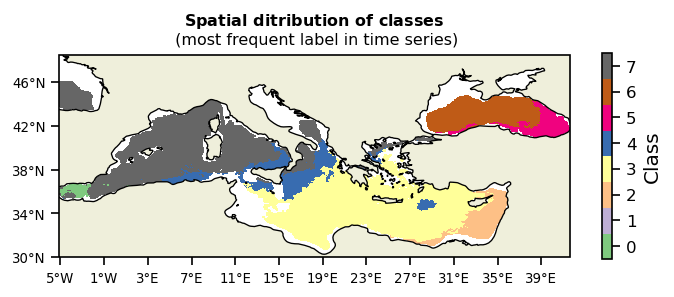

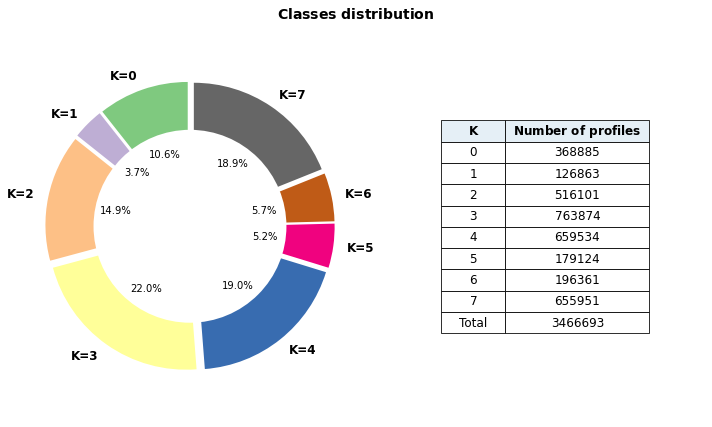

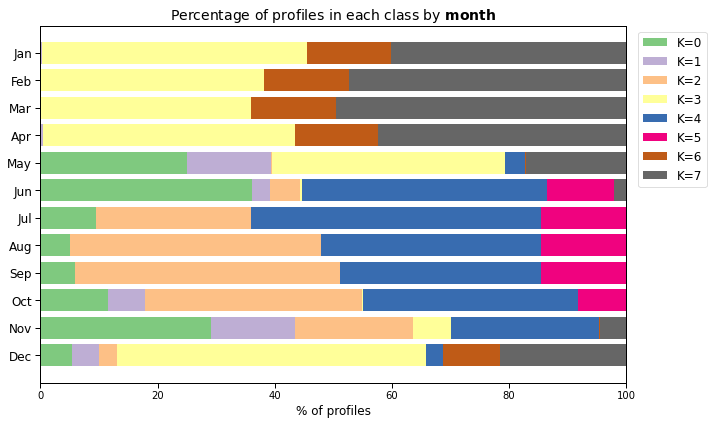

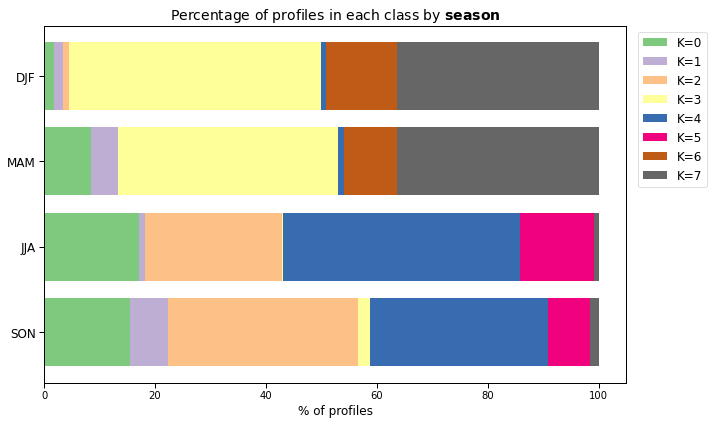

Timer unit: 1e-06 s

Total time: 47.5612 s
File: /home1/datahome/lbachelo/Documents/speed_test/preprocessing_utils.py
Function: generate_plots at line 111

Line #      Hits         Time  Per Hit   % Time  Line Contents
   111                                           def generate_plots(ds, var_name_ds, k, algorithm):
   112                                               """
   113                                               Generates and saves the following plots:
   114                                               - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
   115                                               - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
   116                                               differences between classes.
   117                                               - Spacial distribution: plot the PCM labels in a map to analyse the

In [14]:
%lprun -f generate_plots generate_plots(ds=ds, var_name_ds=var_name_ds, k=k, algorithm=algorithm)